In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
Ts = 1/12
c = 20
eta = 0.9

case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_{}-{}_LDESDur_4-12'


ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

### Price Stats

In [23]:
# Initialize lists to hold DataFrames
mean_prices_dfs = []
std_prices_dfs = []

In [24]:
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(round(1-ratio,1), ratio)
    try:
        # Try to read the CSV file for the current case
        price = pd.read_csv('output/'+case+'/EDprice.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue

    # Calculate stats and transpose
    pricestats = pd.concat([price.mean()*12, (price*12).std()], axis=1).T

    # Now, instead of appending Series objects, you create DataFrame slices for each and append them
    mean_prices_dfs.append(pricestats.iloc[[0]])
    std_prices_dfs.append(pricestats.iloc[[1]])

In [25]:
# Convert lists of series to DataFrames
mean_prices_df = pd.concat(mean_prices_dfs).reset_index(drop=True)
std_prices_df = pd.concat(std_prices_dfs).reset_index(drop=True)
mean_prices_df.index = ratios
std_prices_df.index = ratios

In [26]:
mean_prices_df

,0,1,2,3,4,5
0.0,51.383366,62.740308,46.663221,6.344997,48.678750,49.302684
0.1,51.454048,62.373509,46.994198,6.283536,48.853617,49.538620
0.2,51.376147,61.908359,46.946395,6.292034,48.867938,49.435047
0.3,51.315343,61.597627,47.052697,6.234799,48.866653,49.479975
0.4,51.276482,61.416905,46.997893,6.293548,48.861576,49.408791
0.5,51.247762,61.227043,47.060607,6.245225,48.871231,49.437628


In [27]:
std_prices_df

,0,1,2,3,4,5
0.0,23.096125,33.051333,25.819143,53.380376,22.136099,25.678871
0.1,22.750893,31.502582,25.203407,53.337763,21.998713,25.074788
0.2,22.585834,30.307066,24.881132,53.311196,22.017984,24.708213
0.3,22.374942,29.493287,24.574840,53.268590,21.939585,24.391284
0.4,22.150964,28.649777,24.264752,53.241702,21.839161,24.040153
0.5,22.068277,28.066526,24.058830,53.232338,21.852509,23.822769


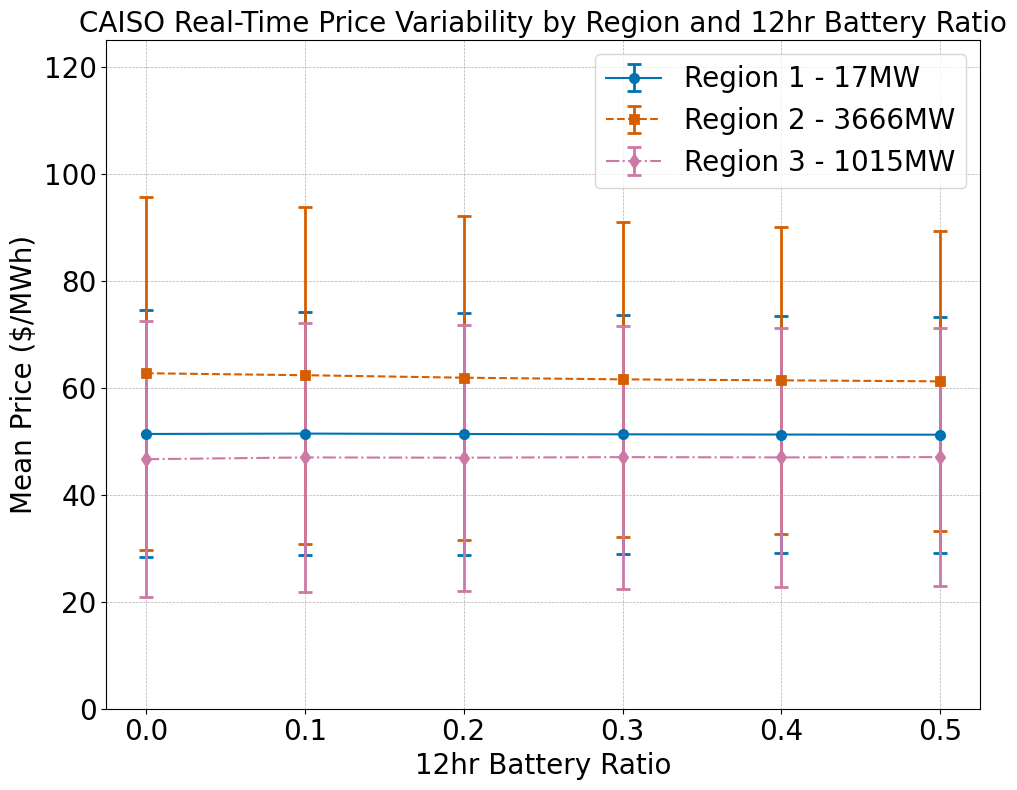

In [28]:
# Assuming mean_prices_df and std_prices_df are already defined
# Selecting the columns for Regions 1, 2, and 3
regions = [0, 1, 2]
mean_prices = mean_prices_df.iloc[:, regions]
std_prices = std_prices_df.iloc[:, regions]

# Preparing ISR values from the index
isr_values = mean_prices.index

# New colors and error bar theme
new_colors = ['#0072B2', '#D55E00', '#CC79A7']  # Updated color palette
new_labels = ['Region 1 - 17MW', 'Region 2 - 3666MW', 'Region 3 - 1015MW']
line_styles = ['-', '--', '-.']  # Different line styles for visual distinction
marker_styles = ['o', 's', 'd']  # Different marker styles for each region
plt.figure(figsize=(10, 8))

for region, color, label, line_style, marker_style in zip(regions, new_colors, new_labels, line_styles, marker_styles):
    plt.errorbar(isr_values, mean_prices.iloc[:, region], yerr=std_prices.iloc[:, region], 
                 label=label, color=color, fmt=line_style + marker_style, capsize=5, elinewidth=2, capthick=2, markeredgewidth=2)

plt.title('CAISO Real-Time Price Variability by Region and 12hr Battery Ratio', fontsize=20)
plt.xlabel('12hr Battery Ratio', fontsize=20)
plt.ylabel('Mean Price ($/MWh)', fontsize=20)
plt.ylim([0, 125])
plt.legend(fontsize=20, loc = 'upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Setting tick parameters for both axes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()

# Save the plot to a file suitable for inclusion in your paper
# plt.savefig('/mnt/data/caiso_price_variability.png', dpi=300)

# Show the plot
plt.show()

### Total System Cost & Avg SOC

In [32]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_{}-{}_LDESDur_4-12'
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
Capacity = 19573.6
# Capacity = 39930.144
# Capacity = 59895.216
# Capacity = 79860.288

total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(round(1-ratio,1), ratio)
    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
        SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append({
                'System Cost': float('nan'),
                'Average SoC': float('nan')
        })
        continue
    CapacityM = Capacity*ratio*3 + Capacity*(1-ratio)
    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    if ratio == 0.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(CapacityM*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_ai = float('nan')
    elif ratio == 1.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(CapacityM*288*364)*100
#         avg_soc_bs = float('nan')
#         avg_soc_ai = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
    else:
        avg_soc = SOC.iloc[:, -12:].sum().sum()/(CapacityM*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -11::2].sum().sum()/(Capacity*288*364*(1-ratio))*100
#         avg_soc_ai = SOC.iloc[:, -12::2].sum().sum()/(Capacity*288*364*ratio)*100
    total_system_costs.append({
                'Total System Cost': total_cost_normalized,
                'Average System SoC': avg_soc,
#                 'Average BS-ES SoC': avg_soc_bs,
#                 'Average AI-ES SoC': avg_soc_ai,       
        })
# Convert the list to a DataFrame
total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average System SoC'])
# total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average BS-ES SoC','Average AI-ES SoC'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df.index = ratios


total_system_costs_df

,Total System Cost,Average System SoC
0.0,1.352236,51.715399
0.1,1.350934,55.395252
0.2,1.349264,58.195655
0.3,1.348149,60.229106
0.4,1.346628,61.727256
0.5,1.345756,62.745298


In [ ]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg5_BAW0_BSESCbid0.5_LDESRatio_{}-{}_LDESDur_4-12'
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
Capacity = 19573.6
# Capacity = 39930.144
# Capacity = 59895.216
# Capacity = 79860.288

total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(round(1-ratio,1), ratio)
    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
        SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append({
                'System Cost': float('nan'),
                'Average SoC': float('nan')
        })
        continue
    CapacityM = Capacity*ratio*3 + Capacity*(1-ratio)
    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    if ratio == 0.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(CapacityM*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_ai = float('nan')
    elif ratio == 1.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(CapacityM*288*364)*100
#         avg_soc_bs = float('nan')
#         avg_soc_ai = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
    else:
        avg_soc = SOC.iloc[:, -12:].sum().sum()/(CapacityM*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -11::2].sum().sum()/(Capacity*288*364*(1-ratio))*100
#         avg_soc_ai = SOC.iloc[:, -12::2].sum().sum()/(Capacity*288*364*ratio)*100
    total_system_costs.append({
                'Total System Cost': total_cost_normalized,
                'Average System SoC': avg_soc,
#                 'Average BS-ES SoC': avg_soc_bs,
#                 'Average AI-ES SoC': avg_soc_ai,       
        })
# Convert the list to a DataFrame
total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average System SoC'])
# total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average BS-ES SoC','Average AI-ES SoC'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df.index = ratios


total_system_costs_df

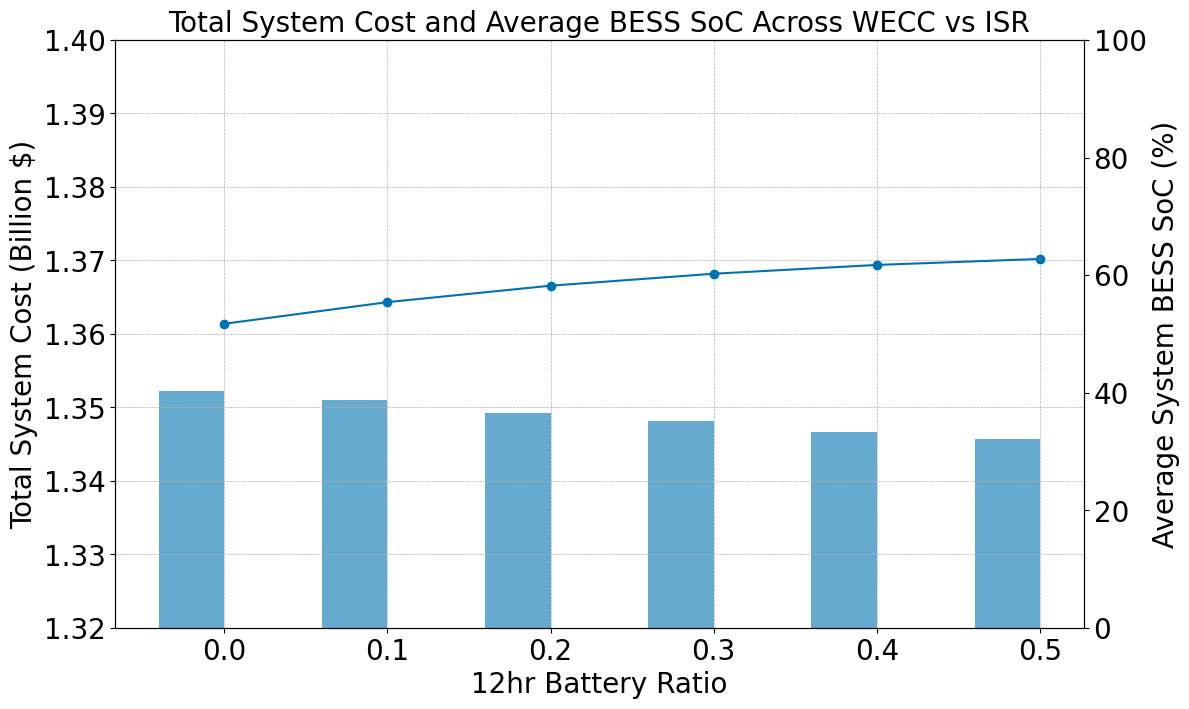

In [33]:
# Define ratios (x-axis values)
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Assuming total_system_costs_df and total_system_costs_df2 are already defined
# Calculate percentage reduction compared to 0.0 ISR
initial_cost1 = total_system_costs_df['Total System Cost'].iloc[0]
# initial_cost2 = total_system_costs_df2['Total System Cost'].iloc[0]

percentage_reduction1 = (total_system_costs_df['Total System Cost'] - initial_cost1) / initial_cost1 * 100
# percentage_reduction2 = (total_system_costs_df2['Total System Cost'] - initial_cost2) / initial_cost2 * 100

# Define bar width and bar positions
bar_width = 0.4
bar_positions1 = np.arange(len(ratios))
bar_positions2 = bar_positions1 + bar_width

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot total system costs
color1 = '#0072B2'
color2 = '#009E73'
ax1.set_xlabel('12hr Battery Ratio', fontsize=20)
ax1.set_ylabel('Total System Cost (Billion $)', fontsize=20)
bar1 = ax1.bar(bar_positions1, total_system_costs_df['Total System Cost'], width=bar_width, color=color1, alpha=0.6, label='Total System Cost - SoC-Independent')
# bar2 = ax1.bar(bar_positions2, total_system_costs_df2['Total System Cost'], width=bar_width, color=color2, alpha=0.6, label='Total System Cost - SoC-Dependent')
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim([1.32, 1.40])

# Instantiate a second y-axis for percentage reduction
ax2 = ax1.twinx()
ax2.set_ylabel('Average System BESS SoC (%)', fontsize=20)

# Plot percentage reductions
line1, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average System SoC'], '-o', color=color1, label='Average System SoC - SoC-Independent')
# line2, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average System SoC'], '-o', color=color2, label='Average System SoC - SoC-Dependent')
# line1, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average BS-ES SoC'], '-o', color=color1, label='Average BS-ES SoC - SoC-Independent')
# line2, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average BS-ES SoC'], '-o', color=color2, label='Average BS-ES SoC - SoC-Dependent')
# line3, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average AI-ES SoC'], '-s', color=color1, label='Average AI-ES SoC - SoC-Independent')
# line4, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average AI-ES SoC'], '-s', color=color2, label='Average AI-ES SoC - SoC-Dependent')
ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylim([0,100])

# Set x-axis ticks to be in the middle of the grouped bars
ax1.set_xticks(bar_positions1 + bar_width / 2)
ax1.set_xticklabels(ratios, fontsize=20)

# Combine legends from both axes
lines = [line1]
# lines = [line1, line2, line3, line4]
bars = [bar1]
# ax1.legend(bars + lines, [bar.get_label() for bar in bars] + [line.get_label() for line in lines], loc='upper right', fontsize=20)

fig.tight_layout()
plt.title('Total System Cost and Average BESS SoC Across WECC vs 12hr Battery Ratio', fontsize=20)
plt.show()

### Loss of load

In [39]:
LL = pd.DataFrame(index=np.arange(0.0, 0.6, 0.1))

In [42]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_{}-{}_LDESDur_4-12'
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
case_name = 'SOC-Independent'

In [43]:
total_system_ll = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(round(1-ratio,1), ratio)
    try:
        # Read the CSV file for the current case
        ll = pd.read_csv(f'output/{case}/EDSlack.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_ll.append(float('nan'))
        continue

    # Sum the total ll
    total_ll = ll.sum().sum()/12
    total_system_ll.append(total_ll)
total_system_ll  

[710.0054105715559,
 525.3019893555512,
 428.10027294222573,
 413.79541177677737,
 345.7222910560361,
 257.74390897159617]

In [44]:
LL[case_name] = total_system_ll
LL

,SOC-Independent
0.0,710.005411
0.1,525.301989
0.2,428.100273
0.3,413.795412
0.4,345.722291
0.5,257.743909


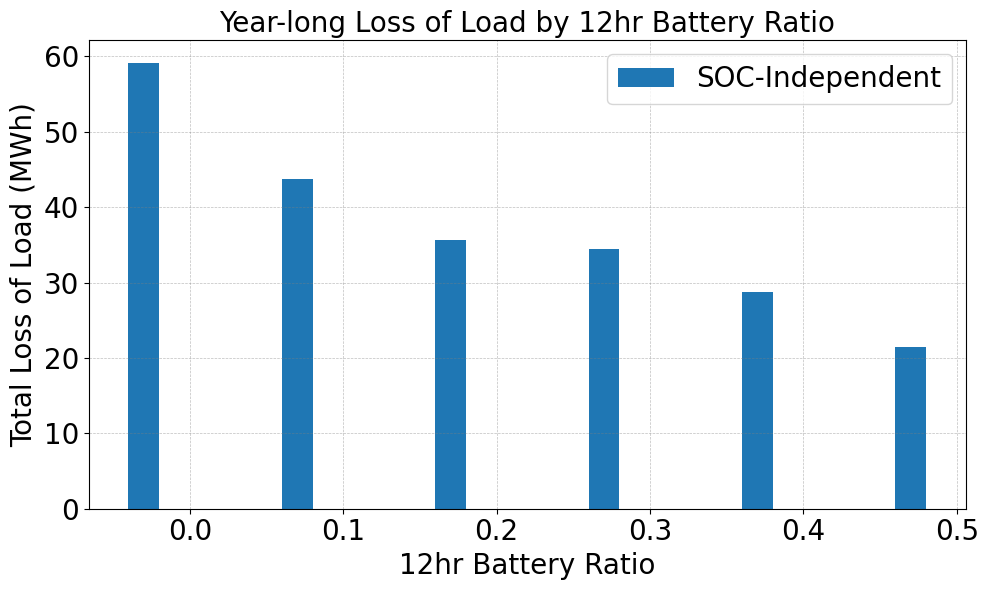

In [65]:
case_names = LL.columns
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(LL.index))  # the label locations
width = 0.2  # the width of the bars
fontsize = 20
# Define colors for related cases
colors = ['#1f77b4', '#ff7f0e', '#aec7e8', '#ffbb78']  # Dark and light shades of blue and orange

for i, name in enumerate(case_names):
    ax.bar(x + i*width - width*1.5, LL[name]/12, width, label=name, color=colors[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('12hr Battery Ratio', fontsize=fontsize)
ax.set_ylabel('Total Loss of Load (MWh)', fontsize=fontsize)
ax.set_title('Year-long Loss of Load by 12hr Battery Ratio', fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels([f"{label:.1f}" for label in LL.index], fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.legend(fontsize=fontsize, title_fontsize=fontsize)

# Beautify the plot
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()

plt.show()

## Storage Profit & Utilization (12hr Battery 0.1-0.5)

In [62]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_{}-{}_LDESDur_4-12'
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
region = 2

# Initialize an empty list to store results
results = []

# Initialize an empty list to store results
results = []

# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    if (ratio <= 0.9) & (ratio >=0.1):
        case = case_template.format(round(1-ratio,1), ratio)
        try:
            # Try to read the CSV file for the current case
            ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
            ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
            price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
            ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
            ES = pd.read_csv('output/'+case+'/Strategic/UPDATED_LDES.csv')
        except FileNotFoundError:
            print(f"File for case {case} not found.")
            continue

        ESID = ESindex[ESindex['Region']==region]['StorageID']
        i = region -1
        AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000
        BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
        AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000
        BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
        AIUnitProfit = AIProfit/ES['EPD'][2*i+35]
        BSUnitProfit = BSProfit/ES['EPD'][2*i+36]
        AICycle = sum(ESD[ESID-1].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+35]
        BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+36]
        
        # Append results to list
        results.append({
            '12 hr Ratio': ratio,
            '4hrRevenue': AIRevenue,
            '12hrRevenue': BSRevenue,
            '4hrProfit': AIProfit,
            '12hrProfit': BSProfit,
            '4hrUnitProfit': AIUnitProfit,
            '12hrUnitProfit': BSUnitProfit,
            '4hrCycle': AICycle,
            '12hrCycle': BSCycle
        })

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results)
results_df


,12 hr Ratio,4hrRevenue,12hrRevenue,4hrProfit,12hrProfit,4hrUnitProfit,12hrUnitProfit,4hrCycle,12hrCycle
0,0.1,39466.474105,28965.553979,-22066.668268,16254.090540,-6.688952,44.343145,259.058533,160.548265
1,0.2,35568.615760,50412.835051,-17944.112842,25774.319442,-6.119216,35.157746,253.453578,155.594631
2,0.3,31741.989059,65775.766019,-14012.576030,29978.051307,-5.461146,27.261262,247.666752,150.710708
3,0.4,27715.812009,76559.047058,-11214.952721,30257.736519,-5.099294,20.636700,245.851579,146.198648
4,0.5,24365.599019,83432.276086,-7593.463316,27190.828214,-4.143179,14.835980,242.189518,142.068093


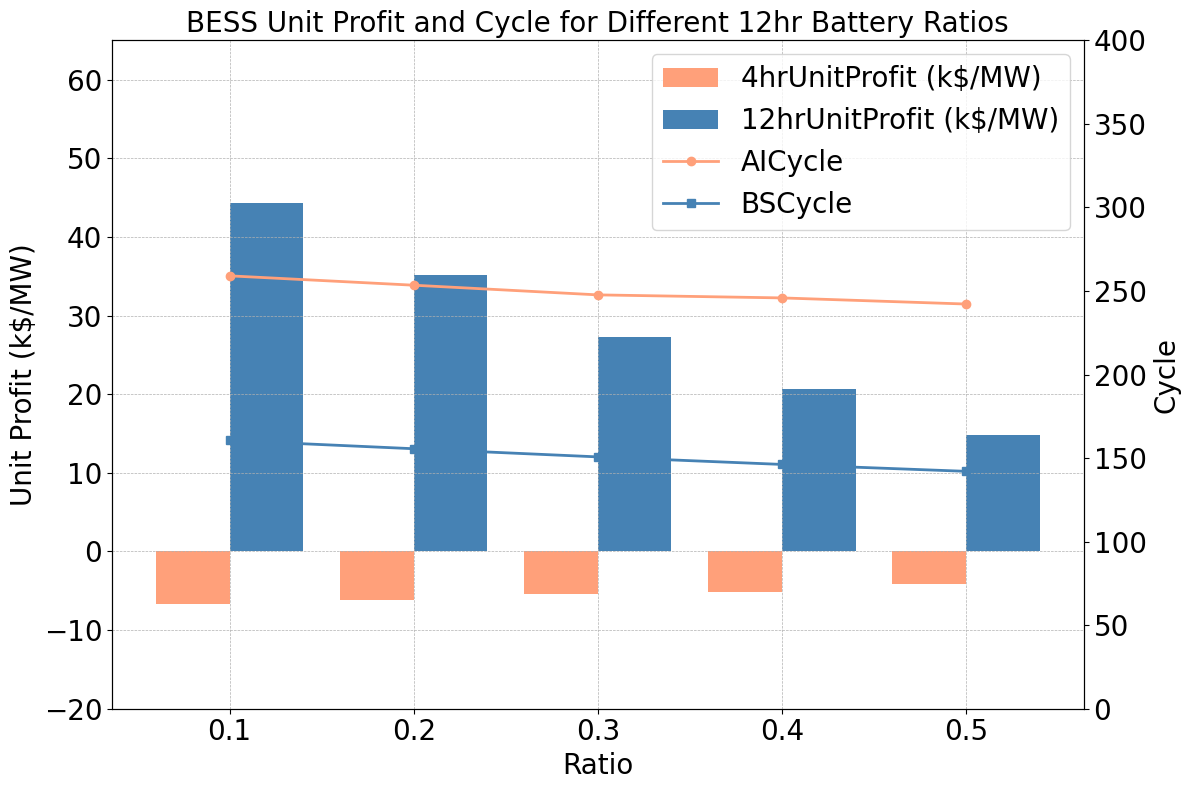

In [64]:
# Define a color palette
colors = ['#FFA07A', '#4682B4', '#FFA07A', '#4682B4']

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Set bar width
bar_width = 0.4
index = range(len(results_df))

# Plotting bars for AIUnitProfit and BSUnitProfit
bar1 = ax1.bar([i - bar_width/2 for i in index], results_df['4hrUnitProfit'], bar_width, label='4hrUnitProfit (k$/MW)', color=colors[0])
bar2 = ax1.bar([i + bar_width/2 for i in index], results_df['12hrUnitProfit'], bar_width, label='12hrUnitProfit (k$/MW)', color=colors[1])

# Adding labels and title for the primary y-axis
ax1.set_xlabel('Ratio', fontsize=20)
ax1.set_ylabel('Unit Profit (k$/MW)', fontsize=20)
ax1.set_xticks(index)
ax1.set_xticklabels(results_df['12 hr Ratio'], fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_ylim([-20, 65])


# Adding a secondary y-axis for AICycle and BSCycle
ax2 = ax1.twinx()
ax2.plot(index, results_df['4hrCycle'], label='4hrCycle', color=colors[2], linestyle='-', marker='o', linewidth=2)
ax2.plot(index, results_df['12hrCycle'], label='12hrCycle', color=colors[3], linestyle='-', marker='s', linewidth=2)
ax2.set_ylabel('Cycle', fontsize=20)
ax2.set_ylim(0, 400)
ax2.tick_params(axis='y', labelsize=20)

# Adding grid lines for better readability
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combining legends
bars_labels = [bar1, bar2]
lines_labels = [plt.Line2D([0], [0], color=colors[2], linestyle='-', marker='o', linewidth=2, label='AICycle'),
                plt.Line2D([0], [0], color=colors[3], linestyle='-', marker='s', linewidth=2, label='BSCycle')]

combined_legend = bars_labels + lines_labels
ax1.legend(handles=combined_legend, loc='upper right', fontsize=20)

# Adding title
plt.title('BESS Unit Profit and Cycle for Different 12hr Battery Ratios', fontsize=20)

# Improving layout
plt.tight_layout()

# Display the plot
plt.show()

In [66]:
# case = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_1.0-2.0-2.0-2.0-2.0'
# case = 'Strategic/Quad/2022/ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_BSESCbid0.5'
case = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_1.0-0.0_LDESDur_4-12'

ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
ES = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Storage_C_4hr_5GW_Strategic_Agg.csv')

In [69]:
ESC[ESID-1].max()

3665.525

In [67]:
i = 1
region = i+1
ESID = region+35
AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1])*price[i])/1000
# BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1])/1000
# BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
AIUnitProfit = AIProfit/ES['MaxCap(MWh)'][ESID-1]
# BSUnitProfit = BSProfit/ES['ESOC'][2*i+1]
AICycle = sum(ESD[ESID-1])/eta*Ts/ES['MaxCap(MWh)'][ESID-1]
# BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+1]
# print(AIRevenue,BSRevenue, AIProfit, BSProfit, AIUnitProfit, BSUnitProfit, AICycle, BSCycle)
print(AIRevenue, AIProfit, AIUnitProfit, AICycle)

44386.97080820008 -25439.995545076825 -1.7350853932981514 264.5784647843483
